In [26]:
import numpy as np
import numpy.random as rnd
import theano
import theano.tensor as T
import lasagne
import time
import gzip
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_mnist_images(filename):
    # Read the inputs in Yann LeCun's binary format.
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8, offset=16)
    # The inputs are vectors now, we reshape them to monochrome 2D images,
    # following the shape convention: (examples, channels, rows, columns)
    data = data.reshape(-1, 28, 28)
    # The inputs come as bytes, we convert them to float32 in range [0,1].
    # (Actually to range [0, 255/256], for compatibility to the version
    # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
    return data

def load_mnist_labels(filename):
    # Read the labels in Yann LeCun's binary format.
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    # The labels are vectors of integers now, that's exactly what we want.
    return data

# We can now download and read the training and test set images and labels.
X_train = load_mnist_images('train-images-idx3-ubyte.gz')
y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

In [3]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

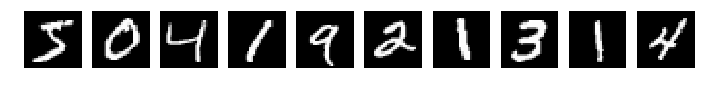

In [4]:
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].reshape((28, 28)), cmap='gray', interpolation='nearest')
    plt.axis('off')

In [5]:
X_train = X_train.reshape((60000, 784))
X_test = X_test.reshape((10000, 784))

In [12]:
a = np.zeros((y_train.size, 10))
a[np.arange(y_train.size), y_train] = 1
y_train = a

In [13]:
a = np.zeros((y_test.size, 10))
a[np.arange(y_test.size), y_test] = 1
y_test = a

In [14]:
NUM_EPOCHS = 100
BATCH_SIZE = 16
GRAD_CLIP = 10
N_HIDDEN = 100
SEQ_LEN = 784
TRAIN_SIZE = 60000
TEST_SIZE = 10000

In [125]:
# numerically stable log-softmax with crossentropy
def logsoftmax(x):
    xdev = x-x.max(1,keepdims=True)
    lsm = xdev - T.log(T.sum(T.exp(xdev),axis=1,keepdims=True))
    return lsm

# cross-entropy
# ys are indices of chars, x is a matrix (? BATCH_SIZE * SEQ_LEN, VOCAB_SIZE)
def lsmCE(x,y):
    print(T.shape(x), T.shape(y))
    return -T.clip(x,-20,0)[T.arange(y.shape[0]), y]

In [15]:
# Технические вещи

# Вспомогательная функция для запаковки результата обучения 
def pack(train_err, train_acc, test_err,test_acc, network, inp, target,train_fn, test_fn):
    return {'train_err':train_err, 
        'train_acc':train_acc, 
        'test_err':test_err, 
        'test_acc':test_acc, 
        'network':network,
        'inp':inp,
        'target':target,
        'train_fn':train_fn, 
        'test_fn':test_fn
           } 

In [16]:
def init_posdef_w():
    R = np.random.normal(size=(N_HIDDEN, N_HIDDEN))
    A = 1 / N_HIDDEN * np.dot(R.T, R)
    eig, _ = np.linalg.eig(A + np.eye(N_HIDDEN))
    e = max(eig)
    W = (A + np.eye(N_HIDDEN)) / e
    return W

In [22]:
def build_network(inp, num_epochs=NUM_EPOCHS):
    # First, we build the network, starting with an input layer
    # Recurrent layers expect input of shape
    # (batch size, max sequence length, number of features)
    l_in = lasagne.layers.InputLayer(shape=(BATCH_SIZE, SEQ_LEN, 1), input_var=inp)

    alpha = np.sqrt(2) * np.exp(1.2 / (max(N_HIDDEN, 6)))
    # We're using a bidirectional network, which means we will combine two
    # RecurrentLayers, one with the backwards=True keyword argument.
    # Setting a value for grad_clipping will clip the gradients in the layer
    l_rnn = lasagne.layers.RecurrentLayer(
        l_in, N_HIDDEN, grad_clipping=GRAD_CLIP,
        W_in_to_hid=lasagne.init.Normal(std=alpha / N_HIDDEN, mean=0.0),
        W_hid_to_hid=init_posdef_w(),
        learn_init=True,
        only_return_final = True,
        nonlinearity=lasagne.nonlinearities.rectify)
    
    l_shp = lasagne.layers.ReshapeLayer(l_rnn, (-1, N_HIDDEN))

    l_out = lasagne.layers.DenseLayer(l_shp, num_units=10,
                                      W=lasagne.init.GlorotNormal(),
                                      nonlinearity=lasagne.nonlinearities.softmax)
    return l_out

In [24]:
def train(Xtrain, ytrain, Xtest, ytest, num_epochs=NUM_EPOCHS):
    print("Building network ...")
    inp = T.tensor3('input')
    target_values = T.imatrix('target_output')
    network = build_network(inp)
    print("The network has {} params".format(lasagne.layers.count_params(network)))
    
    train_size = len(ytrain)
    test_size = len(ytest)
    num_train_batches = train_size // BATCH_SIZE
    num_test_batches = test_size // BATCH_SIZE
    train_err=np.zeros(NUM_EPOCHS)
    train_acc=np.zeros(NUM_EPOCHS)
    test_err=np.zeros(NUM_EPOCHS)
    test_acc=np.zeros(NUM_EPOCHS)
    
    # lasagne.layers.get_output produces a variable for the output of the net
    network_output = lasagne.layers.get_output(network)
    # The value we care about is the final value produced for each sequence
    # first dim of predicted_values is BATCH_SIZE
    # Our cost will be mean-squared error
    cost = T.mean(lasagne.objectives.categorical_crossentropy(network_output, target_values))
    # Retrieve all parameters from the network
    all_params = lasagne.layers.get_all_params(network)
    # Compute SGD updates for training
    print("Computing updates ...")
    all_grads = T.grad(cost, all_params)
    scaled_grads = lasagne.updates.total_norm_constraint(all_grads, GRAD_CLIP)
    lr_var = theano.shared(1e-4)
    updates = lasagne.updates.sgd(scaled_grads, all_params, learning_rate=lr_var)
    # Theano functions for training and computing cost
    print("Compiling functions ...")
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    acc_score = (test_prediction * target_values).sum()/1./target_values.shape[0]*100
    
    train_fn = theano.function([inp, target_values], [cost, acc_score], updates=updates, allow_input_downcast=True)
    test_fn = theano.function([inp, target_values], [cost, acc_score], allow_input_downcast=True)

    for epoch in range(NUM_EPOCHS):
        start_time = time.time()
        if epoch == 33:
            lr_var.set_value(1e-5)
        if epoch == 66:
            lr_var.set_value(1e-6)
        for batch in range(num_train_batches):
            idx = np.random.randint(TRAIN_SIZE, size=BATCH_SIZE)
            err, acc = train_fn(Xtrain[idx, :, np.newaxis], ytrain[idx])
            train_err[epoch] += err
            train_acc[epoch] += acc
        train_err[epoch] /= num_train_batches
        train_acc[epoch] /= num_train_batches
        
        terr, tacc = test_fn(Xtest[:, :, np.newaxis], ytest)
        test_err[epoch] = terr
        test_acc[epoch] = tacc
        
        print("Epoch {} \t loss / accuracy test = {:.4f}, {:.4f} \t train = {:.4f}, {:.4f} \t time = {:.2f}s".
              format(epoch, test_err[epoch], test_acc[epoch], 
                     train_err[epoch], train_acc[epoch],time.time() - start_time))
    return pack(train_err, train_acc, test_err, test_acc,
                network, inp, target_values, train_fn, test_fn)

In [ ]:
model1 = train(X_train, y_train, X_test, y_test)

Building network ...
The network has 11310 params
Computing updates ...
Compiling functions ...
Epoch 0 	 loss / accuracy test = 2.3018, 10.0085 	 train = 2.3020, 10.0063 	 time = 1807.15s
Epoch 1 	 loss / accuracy test = 2.3013, 10.0142 	 train = 2.3015, 10.0119 	 time = 1796.16s
Epoch 2 	 loss / accuracy test = 2.3008, 10.0212 	 train = 2.3009, 10.0191 	 time = 1856.95s
Epoch 3 	 loss / accuracy test = 2.3000, 10.0312 	 train = 2.3003, 10.0278 	 time = 1838.85s
Epoch 5 	 loss / accuracy test = 2.2968, 10.0903 	 train = 2.2974, 10.0745 	 time = 1812.64s
Epoch 6 	 loss / accuracy test = 2.2894, 10.2941 	 train = 2.2918, 10.1981 	 time = 1837.05s
Epoch 7 	 loss / accuracy test = 2.1977, 13.2461 	 train = 2.2496, 11.6234 	 time = 1782.43s
Epoch 9 	 loss / accuracy test = 2.0887, 15.9822 	 train = 2.0881, 15.7338 	 time = 1767.66s
Epoch 10 	 loss / accuracy test = 2.0532, 16.0277 	 train = 2.0635, 16.0233 	 time = 1749.00s
Epoch 11 	 loss / accuracy test = 2.0359, 15.6118 	 train = 2.0374

NameError: name 'target' is not defined